# MODELING AND ANALYZING THE AT2017GFO KILONOVA

In [2]:
from astropy.io import fits

#Open source data from the LIGO observatory (Washington and livingston centres) from the vizier data archive
#https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/MNRAS/493/3379/tablea3
file = fits.open('asu2.fit')


In [3]:
data = file[1].data
file.close()

#Data contains 4 columns, Luminosity, AB magnitude, Filter and Time
#luminosity – the actual brightness (physical energy) of the kilonova. absolute magnitude – How bright the kilonova seems at a distance of 10pc

### LUMINOSITY VS TIME LIGHT CURVE INTERPRETATION

- The luminosity the the Ultraviolet (U) and Blue (B) bands peak earlier and then decline as time increases.
- This can be explained due to the creation of heavy elements (such as lanthanides) by the R-process and their subsequent radioactive decay. The increased opacity of the ejecta (k) leads to the absorption of more Blue/UV light which is later re-emitted at lower Red and Infrared wavelength.
- This increase in Red and Infrared light at later times is reflected in the light curve, where the R and I bands peak.
- Luminosity refers to the spectral luminosity in each filter.

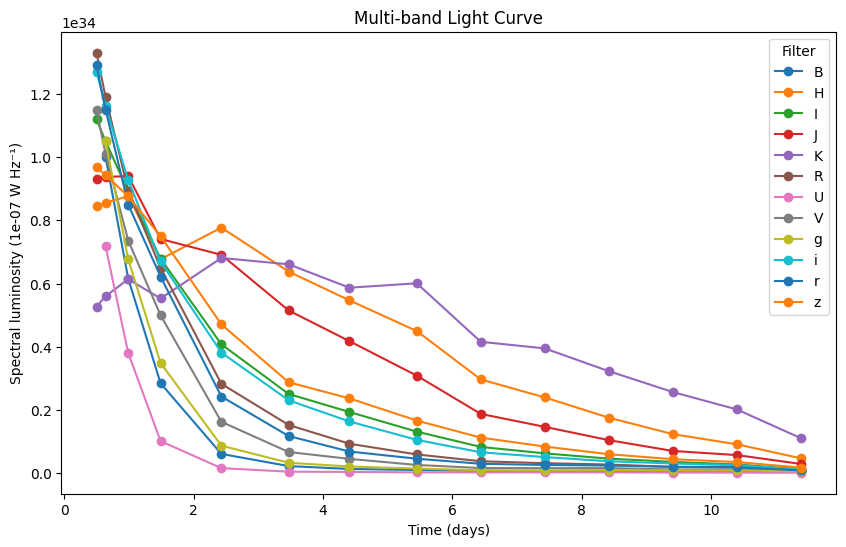

In [4]:
import matplotlib.pyplot as plt
import numpy as np

filters = np.unique(data['Filter']) #finds all unique filter values like 'U', 'B' 'R' etc.
plt.figure(figsize=(10, 6))

for f in filters:
    mask = data['Filter'] == f #creates a boolean array called mask that is true where the Filter matches the current filter and
                                #false where not
    time = data['Time'][mask].astype(float) #gets the time for values in that filter
    lum = (data['Lum'][mask].astype(float)*1e+7) #gets the luminosity for values in that filter
    plt.plot(time, lum, marker='o', linestyle='-', label=f if hasattr(f, 'decode') else f) 

plt.xlabel('Time (days)')
plt.ylabel('Spectral luminosity (1e-07 W Hz⁻¹)')
plt.title('Multi-band Light Curve')
plt.legend(title='Filter')
plt.show()

### Magnitude vs Time

- The magnitude in the data was the ABSOLUTE magnitude, or the magnitude when viewed from a distance of 10 Parsec, which I converted to an apparent magnitude at a distance of 40Mpc, about the actual distance of the Kilonova from the merger.
- We know that magnitudes work in reverse (log scale of luminosity) , a.k.a, a 'higher' magnitude of 24 is actually LESS bright as compared to a lower magnitude of 17, which is MORE bright.
- Again, we see the UV and B band peak earlier around t ∽ 0.5-1 day and start to drop quickly, showing that the blue component starts to disappear, whilst the R and I bands decrease much slower, showing the evolution from a blue component to a red one.
- The brightness in all filters eventually decreases as described by the radioactive heating rate declining as a POWER LAW after the merger (∝t⁻¹∙³). 

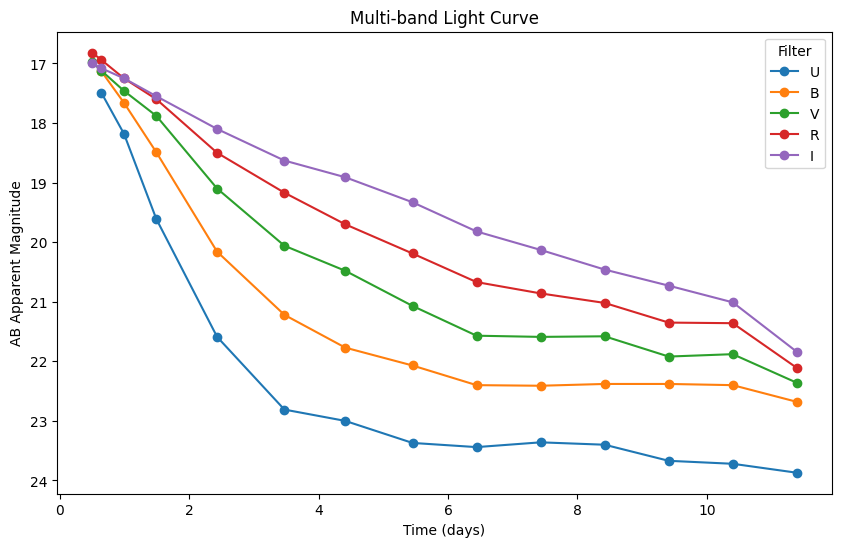

In [5]:
import matplotlib.pyplot as plt
import numpy as np

filters = np.unique(data['Filter']) #finds all unique filter values like 'U', 'B' 'R' etc.
plt.figure(figsize=(10, 6))

for f in ['U', 'B', 'V', 'R', 'I']:
    mask = data['Filter'] == f #creates a boolean array called mask that is true where the Filter matches the current filter and
                                #false where not
    time = data['Time'][mask].astype(float) #gets the time for values in that filter
    mag = data['Mag'][mask].astype(float)  #gets the ABSOLUTE magnitude for values in that filter
    distance_modulus = 5 * np.log10(40e6) - 5  # calculating the distance modulus to convert an absolute mag to an apparent mag when viewed from 40 Mpc in parsecs 
    m_obs_apparent = [m+distance_modulus for m in mag] #convert absolute magnitude to apparent magnitude at 40 Mpc
    plt.plot(time, m_obs_apparent, marker='o', linestyle='-', label=f if hasattr(f, 'decode') else f) 

plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('AB Apparent Magnitude')
plt.title('Multi-band Light Curve')
plt.legend(title='Filter')
plt.show()

### Color Indexes 
- CI = Mag(ɑ) - Mag(ʙ)
- Where both magnitudes are AB absolute.
- The lower the color index, the brighter the curve is in band ɑ and vice versa.
- For the B-R color index, we see an increase around t ∽ 0.5 - 1, the same time the kilonova starts to become brighter in the R filter and dimmer in the B filter.
- The U-R color index is even greater. This is because the U band is more ultraviolet (shorter wavelength) than the B band, which probes the blue part of the optical range.
- At early times, the kilonova is very hot and emits strong UV and blue light, but its flux drops off steeply moving from B/U to R/I bands due to increasing opacity and absorption in the UV part of the spectrum.
- The U band is more sensitive to absorption from lanthanides and other heavy elements, which strongly suppress UV flux (amount of UV light passing through a surface), causing U magnitudes to be fainter (larger numerically) than B magnitudes.
- The R band, being much redder, sees relatively less flux attenuation compared to U or B, so the difference U–R is naturally larger than B–R under typical kilonova spectral energy distributions.

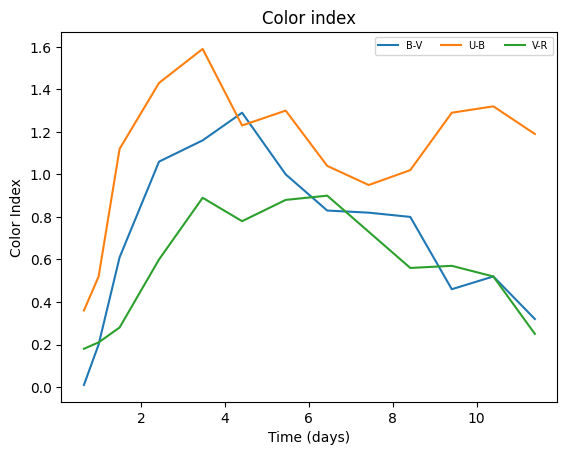

In [16]:
from scipy import interpolate
mag_r, time_r, mag_b, time_b, mag_u ,time_u,mag_v,time_v = [], [],[],[],[],[],[],[]
col_index_bv = {}
col_index_ub = {}
col_index_vr = {}
for line in data:
    if line['Filter'] == 'B':
        mag_b.append(line['Mag'])
        time_b.append(line['Time'])
        
    if line['Filter'] == 'R':
        mag_r.append(line['Mag'])
        time_r.append(line['Time'])

    if line['Filter'] == 'U':
        mag_u.append(line['Mag'])
        time_u.append(line['Time'])

    if line['Filter'] == 'V':
        mag_v.append(line['Mag'])
        time_v.append(line['Time'])

mag_r.pop(0) #none of the other filters contain a magnitude at time '0.5', so i remove that value in the R filter's data set to make it more accurate.
time_r.pop(0)
time_v.pop(0) #same for v
mag_v.pop(0)
# f_b_interp = interpolate.interp1d(time_b, mag_b, kind='linear', fill_value="extrapolate")
# mag_b_synced = f_b_interp(time_v)
# print(time_b, time_v, sep="! ")
# print(mag_b, mag_v, sep="! ")
f = interpolate.interp1d(time_b, mag_b, fill_value='intrapolate') #extrapolated values fitting the other bands to the R band. Less accurate.
# time_b.insert(0, np.float64(0.5))
# mag_b.insert(0, f(time_b[0]))
for i in range(len(mag_r)):
    col_index_bv[(mag_b[i] - mag_v[i]).astype(float)] = time_v[i]
    col_index_ub[(mag_u[i] - mag_b[i]).astype(float)] = ((time_u[i] + time_b[i])/2).astype(float)
    col_index_vr[(mag_v[i] - mag_r[i]).astype(float)] = ((time_v[i] + time_r[i])/2).astype(float)
plt.plot(col_index_bv.values(), col_index_bv.keys(),'-', label="B-V") 
plt.plot(col_index_ub.values(), col_index_ub.keys(),'-', label="U-B") 
plt.plot(col_index_vr.values(), col_index_vr.keys(),'-', label="V-R") 
plt.xlabel('Time (days)')
plt.ylabel('Color Index')
plt.title('Color index')
plt.legend(loc='upper right', fontsize = 7, ncol = 3)
plt.show()


### Generating Synthetic Light Curves Using The pre-defined kilonova-heating-rate Model
- The lightcurve() function calculates the bolometric luminosity (𝐿𝑏𝑜𝑙(𝑡)) of the kilonova over time. It uses mass, velocity, and the power law exponent to compute:
Luminosity: This comes from an integral equation (shown below) modeling the overall energy released.
Temperature: This is derived using the Stefan-Boltzmann law.
Black body Radius: This tells us the size of the visible surface of the kilonova by treating it as a black body to get an approximation of the actual radius.
- Note: Luminosity here is used to refer to the BOLOMETRIC luminosity, which is the total energy provided by the kilonova across all filters accounting for the thermalization energy given by the formula:
  
  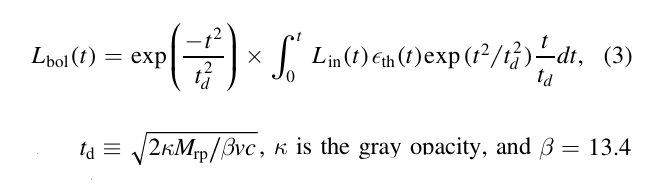

  [Villar 2017]
- I then define bandpasses for the filters U, B, V, R and I using synphot, to get the apparent magnitude in each one.
- Then, I calculate the SEDs (spectral energy distribution) by creating a blackbody spectrum for each temperature in the temperature array (t[]).
- I then scale the spectrums by a factor of π*(r/DL)^2 to get the flux we recieve on Earth, because the function originally calculates the surface intensities of the Kilonova. (Note: DL is 40Mpc, the estimated distance of the kilonova from the merger)
- synphot's Observation function then gives me the value of each of these SEDs when viewed through the bandpasses (filter) defined in bandpass_labels in apparent AB magnitude units
- Using all this information, I finally plot the temperature, luminosity and magnitude curves
- For now, the synthetic curve resembles the observed one very closely since I'm using values of opacities, velocities and mass previously tested and confirmed in some peer-reviewed research articles on this topic (examples attached below)

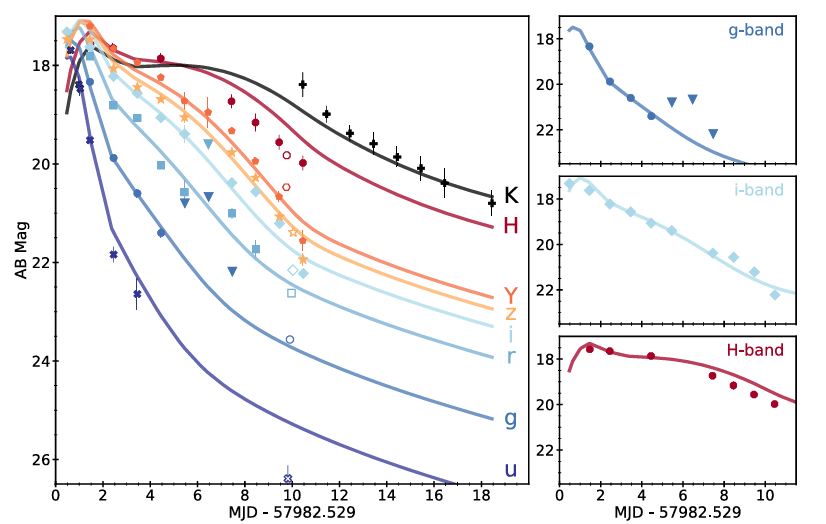  
### [Cowperthwaite 2017]

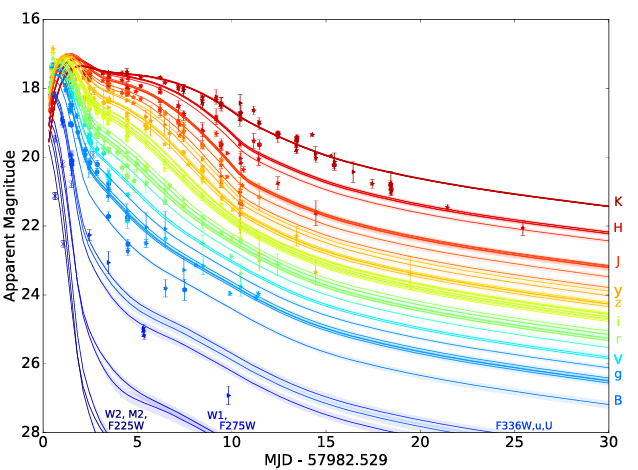
### [Villar 2017]

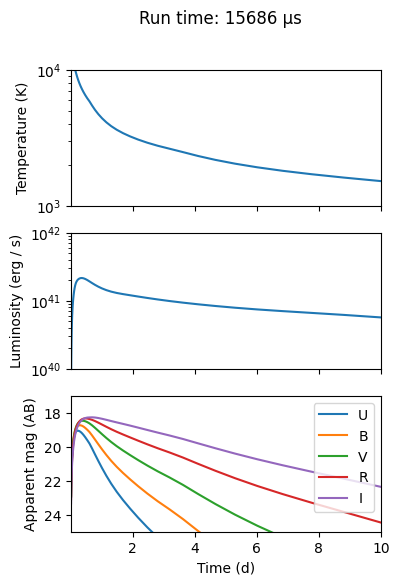

In [8]:
import timeit
from astropy import constants as c
from astropy import units as u
from kilonova_heating_rate import lightcurve
from matplotlib import pyplot as plt
import numpy as np
import synphot

mass = 0.05 * u.Msun
velocities = np.asarray([0.1, 0.2, 0.3, 0.4]) * c.c
opacities = np.asarray([10.0, 3.0, 0.5]) * u.cm**2 / u.g
n = 4.5
t = np.geomspace(0.02, 10) * u.day

L, T, r = lightcurve(t, mass, velocities, opacities, n)

timing = int(np.round(1e6 * np.median(timeit.repeat(
    'lightcurve(t, mass, velocities, opacities, n)',
    globals=globals(), number=1, repeat=10))))

#evaluating flux in band at a distance of 40 Mpc for some predefined 'johnson' filters.
DL = 40 * u.Mpc
bandpass_labels = 'UBVRI'
bandpasses = [
    synphot.SpectralElement.from_filter(f'johnson_{label}')
    for label in bandpass_labels]
seds = [
    synphot.SourceSpectrum(synphot.BlackBody1D, temperature=TT)
    * np.pi * (rr / DL).to(u.dimensionless_unscaled)**2
    for TT, rr in zip(T, r)]

#converting the same observations to AB magnitudes for plotting/comparison.
abmags = [
    [synphot.Observation(sed, bandpass).effstim(u.ABmag).value for sed in seds]
    for bandpass in bandpasses]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(4, 6))
fig.suptitle(f'Run time: {timing} µs')
ax1.plot(t, T)
ax2.plot(t, L)
for label, abmag in zip(bandpass_labels, abmags):
    ax3.plot(t, abmag, label=label.upper())
ax3.set_xlabel(f'Time ({t.unit})')
ax1.set_ylabel(f'Temperature ({T.unit})')
ax2.set_ylabel(f'Luminosity ({L.unit})')
ax3.set_ylabel('Apparent mag (AB)')
ax3.set_ylim(17,25) #centering the plot in the middle of the windiw
ax1.set_xlim(0.01, 10)
ax1.set_ylim(1e3, 1e4)
ax2.set_ylim(1e40, 1e42)
ax3.invert_yaxis()
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.legend()
plt.show()


# Varying opacities of the ejecta 
- For now, I create 3 arrays containing different combinations of opactities of the three components of the Kilonova.
- I vary only the first parameter of these arrays, since that represents the innermost component of the kilonova, where lanthanide formation takes place.
- I choose three such options- low, medium and high inner-component opacities.
- As expected, high lanthanide opacity leads to a dimmer, longer duration kilonova light curve.
- The lowest opacity results in a small jump in luminosity, since it is easier for energy to escape. It is characterized by the early peak.
- Medium opacity results in a more moderate decrease in luminosity of the kilonova.
- Just from the plot, we can see that a curve between medium and high opacity mimics our original data.
- For the color indices, I also calculate Apparent AB magnitudes in the bandpasses UBVR. Every row in abmags contains a transformd SED value from seds[], where every column corresponds to the value when viewed from a bandpass in bandpass labels.
- Basically, abmags[0][0] = SED[0] viewed from bandpass[0].

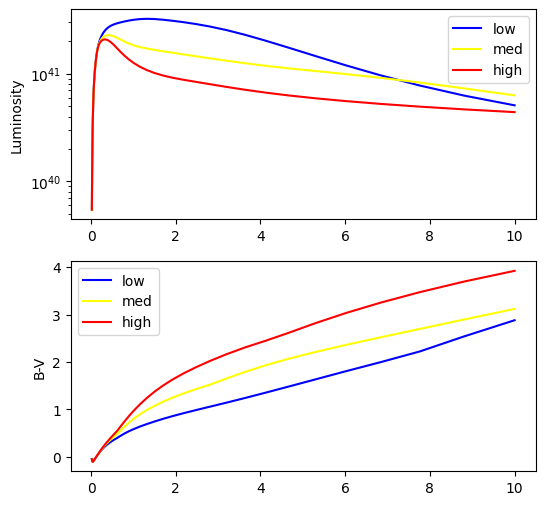

In [11]:

opacities = {
    'low': np.asarray([1.0, 1.0, 0.5]) * u.cm**2 / u.g,
    'med': np.asarray([5.0, 2.0, 0.5]) * u.cm**2 / u.g,
    'high': np.asarray([20.0, 5.0, 0.5]) * u.cm**2 / u.g
}

fig, (axL, axBV) = plt.subplots(2, 1, figsize=(6, 6))

#since low opacity = bluer light, i chose those colors to represent that a bit
colors = ['blue', 'yellow', 'red']

for i, (name, ops) in enumerate(opacities.items()):
    L, T, r = lightcurve(t, mass, velocities, ops, n)
    
    #I'm extracting the bandpasses I used above for the color indices so its easy to compare
    bandpass_labels = 'BV'
    bandpasses = [synphot.SpectralElement.from_filter(f'johnson_{label}') for label in bandpass_labels]
    #converting the same observations to AB magnitudes for plotting/comparison.
    seds = [synphot.SourceSpectrum(synphot.BlackBody1D, temperature=TT)* np.pi * (rr / DL).to(u.dimensionless_unscaled)**2 for TT, rr in zip(T, r)]
    abmags = np.array([[synphot.Observation(sed, bp).effstim(u.ABmag).value for bp in bandpasses] for sed in seds], dtype=float)
    b_mag = abmags[:,0]
    v_mag = abmags[:,1]
    b_v = b_mag - v_mag
    axL.plot(t.value, L, color=colors[i], label=name)
    axBV.plot(t.value, b_v, color=colors[i], label=name)
    
axL.set_yscale('log')
axL.set_ylabel('Luminosity')
axL.legend()
axBV.set_ylabel('B-V')
axBV.legend()

plt.show()